In [1]:
try:
    from imports import *
except ModuleNotFoundError:
    import sys; sys.path.append("../../")
    from imports import *

# Quantum dot-like plasmonic modes in twisted bilayer graphene supercells

In [335]:
prefix = Path("data")
os.makedirs("./assets", exist_ok=True)

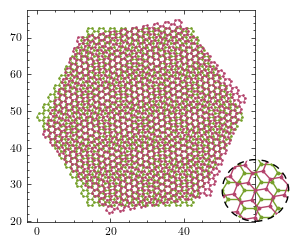

In [317]:
with plt.style.context(["science", "scatter", style, {"axes.axisbelow": True}]):
    w, h = style["figure.figsize"]
    fig, ax = plt.subplots(figsize=(0.6 * w, 0.6 * w))
    t = pd.read_csv(prefix / "Figure_1/bilayer_graphene_lattice_10.csv",
                    names=["x", "y", "z", "sublattice"])
    es = np.loadtxt(prefix / "Figure_1/bilayer_graphene_edges_10.csv", delimiter=",").astype(int)

    def _graph(ax, scale=1):
        m, s = [lambda x: x <= 2, lambda x: x > 2], t.sublattice
        for k in range(2):
            i, j = es[np.asarray(m[k](s[es[:, 0]])) & np.asarray(m[k](s[es[:, 1]]))].T
            ax.add_collection(LineCollection(np.column_stack([t.x[i], t.y[i], t.x[j], t.y[j]]).reshape(-1, 2, 2),
                edgecolor=my_cmap2(k), zorder=-1 + k, linewidth=scale * 0.5))
            _t = t[m[k](s)]
            ax.scatter(_t.x, _t.y, s=scale**2 * 0.8, color=my_cmap2(k), marker="o", zorder=-0.5 + k)
            
    _graph(ax)
    
    x0, y0 = t.x[842], t.y[842]
    axins = ax.inset_axes([0.85, 0.0, 0.3, 0.3],
        xlim=(x0 - 3.1, x0 + 3.1), ylim=(y0 - 3.1, y0 + 3.1), xticklabels=[], yticklabels=[])
    axins.axis("off")
    _graph(axins, scale=2)
    
    patch = matplotlib.patches.Circle((x0, y0), radius=3, transform=axins.transData,
                                      edgecolor="black", linestyle=(0, (5, 4)), linewidth=1, facecolor="none")
    for c in itertools.chain(axins.lines, axins.collections): c.set_clip_path(patch)
    axins.add_artist(patch)
    
    ax.set_aspect("equal")
    ax.set_rasterized(True)
    fig.savefig("assets/Figure_1.pgf", backend="pgf", dpi=600)

fig

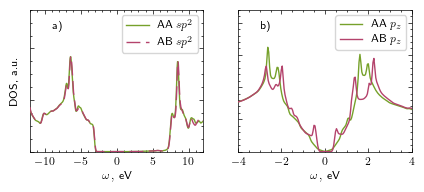

In [318]:
def _load_dft_dos(s):
    t = np.loadtxt(prefix / "Figure_2" / s)
    return pd.DataFrame({"e": t[:, 0], "sp2": t[:, 1] + t[:, 2] + t[:, 4], "pz": t[:, 3]})
    
aa = _load_dft_dos("02_BL_AA/H_25_K_18_B_128_d_3.35/01_DFT/dosp.001.dat"); aa["e"] -= 0.28
ab = _load_dft_dos("03_BL_AB/H_25_K_18_B_128_d_3.35/01_DFT/dosp.001.dat")
with plt.style.context(["science", "scatter", style, {"axes.axisbelow": True}]):
    w, h = style["figure.figsize"]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(w, h / 2))
    ax1.plot(ab["e"], gaussian_filter(ab["sp2"], sigma=2.5), label=r"AA $sp^2$", marker="none", linestyle="-")
    ax1.plot(aa["e"], gaussian_filter(aa["sp2"], sigma=2.5), label=r"AB $sp^2$", marker="none", dashes=[10, 4])
    ax1.set_xlabel(r"$\omega\,,$ eV"); ax1.set_ylabel(r"DOS, a.u.")
    ax1.set_xlim((-12, 12)); ax1.set_ylim((-0.001, 0.55)); ax1.tick_params(axis='both', labelleft=False)
    ax1.set_xticks([-10, -5, 0, 5, 10]);
    ax2.plot(ab["e"], gaussian_filter(ab["pz"], sigma=1, mode="constant"), label=r"AA $p_z$", marker="none", linestyle="-")
    ax2.plot(aa["e"], gaussian_filter(aa["pz"], sigma=1, mode="constant"), label=r"AB $p_z$", marker="none", linestyle="-")
    ax2.set_xlabel(r"$\omega\,,$ eV");
    ax2.set_xlim((-4, 4)); ax2.set_ylim((-0.0005, 0.22)); ax2.tick_params(axis='y', labelleft=False)
    ax1.text(-9, 0.475, "a)"); ax2.text(-3, 0.19, "b)")
    ax1.legend(); ax2.legend()
    for ax in [ax1, ax2]:
        for spine in ax.spines.values(): spine.set_zorder(-1)
    fig.savefig("assets/Figure_2.pgf", backend="pgf")  
fig

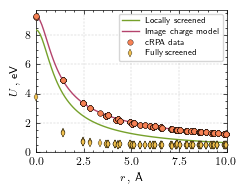

In [320]:
with plt.style.context(["science", "scatter", style]):
    w, h = style["figure.figsize"]
    fig, ax = plt.subplots(figsize=(w / 2, h / 2))
    
    delta, eps = 0.7626534576229569, 2.2597469530289955
    bare = lambda x: 14.39964547842567 / (eps * np.sqrt(x**2 + delta**2))
    ax.plot(np.linspace(0, 10, 100), bare(np.linspace(0, 10, 100)),
            label="Locally screened")

    t = pd.read_csv(prefix / "Figure_3/image_charge_model.csv", names=["r", "W"])
    t = t[t.r <= 10]
    ax.plot(t.r, t.W, label="Image charge model", clip_on=False)

    
    t = pd.read_csv(prefix / "Figure_3/coulomb_cRPA.csv", names=["r", "W"])
    t = t[t.r <= 10]
    ax.plot(t.r, t.W, marker="o", markersize=4, markeredgewidth=0.25, markeredgecolor='black', linestyle="none",
            label="cRPA data", clip_on=False)

    c = 842
    p = pd.read_csv(prefix / "Figure_1/bilayer_graphene_lattice_0.csv", names=["x", "y", "z", "sublattice"]) \
      .assign(W=np.loadtxt(prefix / "Figure_3/fully_screened.csv")) \
      .assign(r=lambda df: 1.42492 * np.linalg.norm(np.column_stack([df.x - df.x[c], df.y - df.y[c], df.z - df.z[c]]), axis=1)) \
      .sort_values(by="r")
    p = p[p.r <= 10]
    ax.plot(p.r, p.W, marker="d", markersize=4, markeredgewidth=0.25, markeredgecolor='black', linestyle="none",
            label="Fully screened", clip_on=False)

    ax.set_axisbelow(True)
    for c in ax.spines.values(): c.set_zorder(0.6)
    ax.set_xlabel(r"$r\,,$ \AA"); ax.set_ylabel(r"$U\,,$ eV")
    ax.set_xlim((0, 10)); ax.grid()
    ax.legend(fontsize=6, labelspacing=0.4)
    fig.savefig("assets/Figure_3.pgf", backend="pgf")

fig

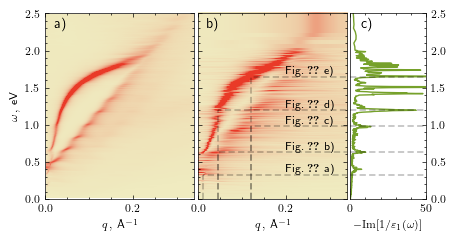

In [321]:
def _select(qs, freq, loss):
    p = (0.005 < freq) & (freq < 2.495); rmin = np.argmax(p); rmax = np.argmin(p[rmin:])
    if rmax == 0: rmax = -1
    p = (7e-4 < qs) & (qs < 0.2); cmin = np.argmax(p); cmax = np.argmin(p[cmin:])
    if cmax == 0: cmax = -1
    return qs[cmin:cmax], freq[rmin:rmax], loss[rmin:rmax, cmin:cmax]

with h5.File(prefix / "Figure_5/compact_dispersion_k=18_μ=1.34_θ=0_0.0_0.005_2.5.h5") as f:
    loss, freq = np.asarray(f["loss"]), np.asarray(f["freq"])
    qs1, freq1, loss1 = _select(np.linspace(0, 0.3, loss.shape[1]), freq, loss)

with h5.File(prefix / "Figure_5/compact_dispersion_k=10_μ=1.34_θ=0.h5") as f:
    loss, freq = np.asarray(f["loss"]), np.asarray(f["freq"])
    qs2, freq2, loss2 = _select(np.linspace(0, 1, loss.shape[1]), freq, loss)

with h5.File(prefix / "Figure_5/compact_loss_k=10_μ=1.34_θ=0.h5") as f:
    loss3, freq3 = np.asarray(f["loss"]), np.asarray(f["freq"])

def _loss(ax, q, freq, loss, scale=1):
    if np.diff(freq).std() > 1e-6:
        im = matplotlib.image.NonUniformImage(ax, interpolation="nearest", extent=(q.min(), q.max(), freq.min(), freq.max()),
                                              norm=matplotlib.colors.Normalize(vmin=0, vmax=3),
                                              cmap=my_cmap4)
        im.set_data(q, freq, loss); ax.add_image(im)
    else:
        cm = ax.imshow(loss, aspect=(q.max() - q.min()) / (freq.max() - freq.min()),
                       vmin=0, vmax=6, extent=(q.min(), q.max(), freq.min(), freq.max()),
                       cmap=my_cmap4, origin="lower") # , interpolation="none")
        return cm

# Graphene high symmetry points
G, K = np.array([0, 0]), 2 * np.pi * (2 / 3 * np.array([2 / 3, 0]) + 1 / 3 * np.array([-1 / 3, 1 / np.sqrt(3)]))
c = np.linalg.norm(G - K) / 1.424919
qs1 = qs1 * c
qs2 = qs2 * c

with plt.style.context(["science", "scatter", style]):
    w = style["figure.figsize"][0]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(w, 0.49 * w), width_ratios=[2, 2, 1])
    fig.subplots_adjust(wspace=0.02)
    _loss(ax1, qs1, freq1, loss1)
    _loss(ax2, qs2, freq2, loss2)
    ax3.plot(loss3,  freq3, linestyle="-", linewidth=1, marker="none")
    ax3.set_ylim((0, 2.5)); ax3.set_xlim((0, 50))
    for ax in [ax1, ax2]: ax.set_xlim((0, 0.2 * c)); ax.set_ylim((0, 2.5)); ax.set_aspect(0.2 * c / (0.8 * 2.5))
    ax1.set_xlabel(r"$q\,,$ \AA$^{-1}$"); ax1.set_ylabel(r"$\omega\,,$ eV")
    ax2.set_xlabel(r"$q\,,$ \AA$^{-1}$"); ax3.set_xlabel(r"$-\mathrm{Im}[1/\varepsilon_1(\omega)]$")
    ax2.sharey(ax1); ax3.sharey(ax1)
    ax2.tick_params(axis='both', which="both", labelleft=False)
    ax3.tick_params(axis='both', which="both", left=False, labelleft=False, labelright=True)
    
    ax1.text(0.02, 2.3, "a)", fontsize=10)
    ax2.text(0.02, 2.3, "b)", fontsize=10)
    ax3.text(7, 2.3, "c)", fontsize=10)

    ax2.add_collection(LineCollection([
        np.array([[0.01, 0.0], [0.01, 0.3225], [0.5, 0.3225]]),
        np.array([[0.045, 0.0], [0.045, 0.63], [0.5, 0.63]]),
        np.array([[0.12, 0.0], [0.12, 0.9775], [0.5, 0.9775]]),
        np.array([[0.045, 0.0], [0.045, 1.195], [0.5, 1.195]]),
        np.array([[0.12, 0.0], [0.12, 1.65], [0.5, 1.65]]),        
    ], linewidth=0.3, linestyle=(0, (15, 8)), color="black"))
    ax3.add_collection(LineCollection([
        np.array([[0, 0.3225], [50, 0.3225]]),
        np.array([[0, 0.63], [50, 0.63]]),
        np.array([[0, 0.9775], [50, 0.9775]]),
        np.array([[0, 1.195], [50, 1.195]]),
        np.array([[0, 1.65], [50, 1.65]]),        
    ], linewidth=0.3, linestyle=(0, (15, 8)), color="black"))
    for i, y in enumerate([0.3225, 0.63, 0.9775, 1.195, 1.65]):
        ax2.text(0.2, y + 0.04, r"Fig.~\ref{fig:mat22:modes}~" + chr(ord("a") + i) + ")") 
    fig.savefig("assets/Figure_5.pgf", backend="pgf")    
fig

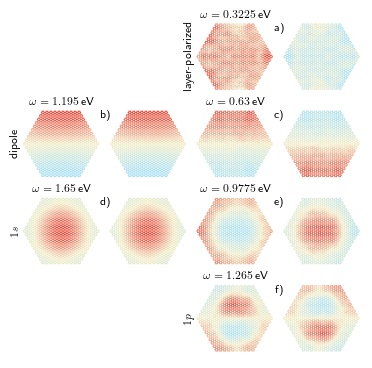

In [325]:
with plt.style.context(["science", "scatter", style]):
    w = style["figure.figsize"][0]
    fig, ax = plt.subplots(4, 4, figsize=(0.9 * w, 0.9 * w))
    fig.subplots_adjust(wspace=0.05, hspace=0.1)

    p = pd.read_csv(prefix / "Figure_1/bilayer_graphene_lattice_0.csv", names=["x", "y", "z", "sublattice"])
    fst, snd = p.sublattice <= 2, p.sublattice > 2
    kwargs = dict(s=1.3, marker="h", zorder=-3, cmap=my_cmap3, edgecolor="none")
    xm, ym = 0.5 * (p.x.min() + p.x.max()), 0.5 * (p.y.min() + p.y.max())

    with h5.File(prefix / "Figure_6/modes_3252_θ=0.h5") as f:
        freq, ms = np.asarray(f["freq"]).tolist(), np.asarray(f["modes"])
        
    def _one(i, j, s, w, label):
        m = ms[freq.index(w)]
        r = np.abs(m).max()
        ax[i][j].text(0.5 * (p.x.min() + p.x.max()), p.y.max() + 5,
                      r"$\omega = " + str(w) + r"\,$eV", horizontalalignment="center")
        ax[i][j].text(p.x.max() + 4, p.y.max() - 5, label, horizontalalignment="center")
        ax[i][j].scatter(p[fst].x, p[fst].y, c=m[fst].real, vmin=-r, vmax=r, **kwargs)
        ax[i][j + 1].scatter(p[snd].x, p[snd].y, c=m[snd].real, vmin=-r, vmax=r, **kwargs)

    _one(1, 0, "1.0_2.0", 1.195, "b)")
    _one(2, 0, "1.63_1.67", 1.65, "d)")
    _one(0, 2, "0.0_1.0", 0.3225, "a)")
    _one(1, 2, "0.0_1.0", 0.63, "c)")
    _one(2, 2, "0.0_1.0", 0.9775, "e)")
    _one(3, 2, "1.0_2.0", 1.265, "f)")

    for c, l in zip([ax[0][2], ax[1][0], ax[2][0], ax[3][2]], ["layer-polarized", r"dipole", r"$1s$", r"$1p$"]):
        c.text(p.x.min() - 10, 0.5 * (p.y.min() + p.y.max()), l, verticalalignment="center", rotation=90)

    for c in itertools.chain(*ax):
        c.set_aspect("equal"); c.tick_params(labelleft=False, labelbottom=False)
        c.set_rasterization_zorder(-2); c.axis("off")

    fig.savefig("assets/Figure_6.pgf", backend="pgf", dpi=600)
fig

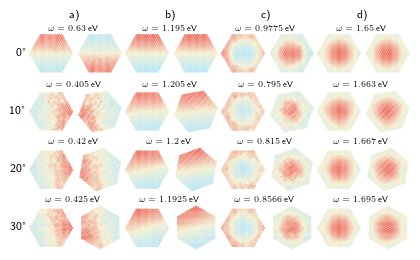

In [338]:
with plt.style.context(["science", "scatter", style]):
    w = style["figure.figsize"][0]
    fig, ax = plt.subplots(4, 8, figsize=(w, 0.6 * w))
    fig.subplots_adjust(wspace=0.05, hspace=0.1)

    def _one(i, j, w, freq, ms, p, flip=False):
        m = ms[freq.index(w)]
        if flip: m = -m
        r = np.abs(m).max()
        kwargs = dict(s=0.5, marker="h", zorder=-3, cmap=my_cmap3, edgecolor="none")
        fst, snd = p.sublattice <= 2, p.sublattice > 2
        ax[i][j].text(p.x.max(), p.y.max() + 5, r"$\omega = " + str(w) + r"\,$eV",
                      fontsize=6, horizontalalignment="center")
        ax[i][j].scatter(p[fst].x, p[fst].y, c=m[fst].real, vmin=-r, vmax=r, **kwargs)
        ax[i][j + 1].scatter(p[snd].x, p[snd].y, c=m[snd].real, vmin=-r, vmax=r, **kwargs)

    info = [(0, [0.63, 1.195, 0.9775, 1.65], []),
            (10, [0.405, 1.205, 0.795, 1.663], [1]),
            (20, [0.42, 1.2, 0.815, 1.667], [0, 1]),
            (30, [0.425, 1.1925, 0.8566, 1.695], [2])]
    for k, (theta, ws, flips) in enumerate(info):
        with h5.File(prefix / f"Figure_7/modes_3252_θ={theta}.h5") as f:
            freq, ms = np.asarray(f["freq"]).tolist(), np.asarray(f["modes"])
        p = pd.read_csv(prefix / f"Figure_1/bilayer_graphene_lattice_{theta}.csv",
                        names=["x", "y", "z", "sublattice"])    
        for j in range(4): _one(k, 2 * j, ws[j], freq, ms, p, j in flips)
        ax[k][0].text(p.x.min() - 5, 0.5 * (p.y.min() + p.y.max()), str(theta) + r"\textdegree",
            verticalalignment="center", horizontalalignment="right", rotation=0)

    p = pd.read_csv(prefix / f"Figure_1/bilayer_graphene_lattice_0.csv",
                    names=["x", "y", "z", "sublattice"]); xlim = (p.x.min() - 1, p.x.max() + 1)
    p = pd.read_csv(prefix / f"Figure_1/bilayer_graphene_lattice_30.csv",
                    names=["x", "y", "z", "sublattice"]); ylim = (p.y.min() - 1, p.y.max() + 1)
    for j, l in zip([0, 2, 4, 6], ["a)", "b)", "c)", "d)"]):
        ax[0][j].text(xlim[1], ylim[1] + 16, l, horizontalalignment="center")
    
    for c in itertools.chain(*ax):
        c.set_xlim(xlim); c.set_ylim(ylim)
        c.set_aspect("equal"); c.tick_params(labelleft=False, labelbottom=False)
        c.set_rasterization_zorder(-2); c.axis("off")

    fig.savefig("assets/Figure_7.pgf", backend="pgf", dpi=600)
fig

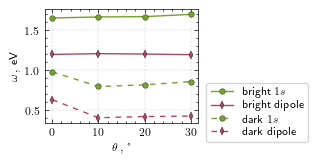

In [337]:
with plt.style.context(["science", "scatter", style,
                        {"lines.markersize": 4, "lines.markeredgewidth": 0.25,
                         "lines.markeredgecolor": "black"}]):
    w, h = style["figure.figsize"]
    fig, ax = plt.subplots(figsize=(0.4 * w, 0.4 * h))

    ts = [0, 10, 20, 30]
    es = [
        [1.65, 1.663, 1.667, 1.695],
        [1.195, 1.205, 1.2, 1.1925],
        [0.9775, 0.795, 0.815, 0.8566],
        [0.63, 0.405, 0.42, 0.425]
    ]
    ax.grid()
    ax.plot(ts, es[0], "C0", marker="o", label=r"bright $1s$")
    ax.plot(ts, es[1], "C1", marker="d", label=r"bright dipole")
    ax.plot(ts, es[2], "C0", dashes=(4, 4), marker="o", label=r"dark $1s$")
    ax.plot(ts, es[3], "C1", dashes=(4, 4), marker="d", label=r"dark dipole")
    ax.set_xticks(np.linspace(0, 30, 4))
    ax.set_xlabel(r"$\theta\,,$ \textdegree"); ax.set_ylabel(r"$\omega\,,$ eV")
    ax.legend(labelspacing=0.3, bbox_to_anchor=(1.02, 0.4))
    fig.savefig("assets/Figure_8.pgf", backend="pgf")
fig
